<a href="https://colab.research.google.com/github/tsutsumi-ozro/NLP-100knocks/blob/main/ch09.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## 第9章: RNN, CNN


### 80. ID番号への変換
問題51で構築した学習データ中の単語にユニークなID番号を付与したい．学習データ中で最も頻出する単語に1，2番目に頻出する単語に2，……といった方法で，学習データ中で2回以上出現する単語にID番号を付与せよ．そして，与えられた単語列に対して，ID番号の列を返す関数を実装せよ．ただし，出現頻度が2回未満の単語のID番号はすべて0とせよ

In [31]:
!wget https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
!unzip /content/NewsAggregatorDataset.zip

--2023-01-13 05:16:13--  https://archive.ics.uci.edu/ml/machine-learning-databases/00359/NewsAggregatorDataset.zip
Resolving archive.ics.uci.edu (archive.ics.uci.edu)... 128.195.10.252
Connecting to archive.ics.uci.edu (archive.ics.uci.edu)|128.195.10.252|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29224203 (28M) [application/x-httpd-php]
Saving to: ‘NewsAggregatorDataset.zip.1’

NewsAggregatorDatas 100%[===================>]  27.87M  10.2MB/s    in 2.7s    

2023-01-13 05:16:17 (10.2 MB/s) - ‘NewsAggregatorDataset.zip.1’ saved [29224203/29224203]

Archive:  /content/NewsAggregatorDataset.zip
replace 2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._2pageSessions.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._newsCorpora.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace readme.txt? [y]es, [n]o, [A]ll, [N]one, [r]ename: n
replace __MACOSX/._readm

In [1]:
#問題50のコードを(基本的に)そのまんま
import pandas as pd
from sklearn.model_selection import train_test_split

columns = ['ID', 'TITLE', 'URL', 'PUBLISHER', 'CATEGORY', 'STORY', 'HOSTNAME', 'TIMESTAMP']
df = pd.read_csv('/content/newsCorpora.csv', header=None, sep='\t', names=columns)

df = df[df['PUBLISHER'].isin(['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail'])]
# df.query("PUBLISHER in ['Reuters', 'Huffington Post', 'Businessweek', 'Contactmusic.com', 'Daily Mail']")
df = df.sample(frac=1, random_state=0)

train, valid_test= train_test_split(df, test_size=0.2, stratify=df['CATEGORY'], random_state=0)
valid, test = train_test_split(valid_test, test_size=0.5, stratify=valid_test['CATEGORY'], random_state=0)
train.reset_index(drop=True, inplace=True)
valid.reset_index(drop=True, inplace=True)
test.reset_index(drop=True, inplace=True)

In [2]:
from collections import defaultdict
import string

d = defaultdict(int)
table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
for text in train['TITLE']:
    for word in text.translate(table).split():
        d[word] += 1
d = sorted(d.items(), key=lambda x: x[1], reverse=True)

word2id = {word: i+1 for i, (word, count) in enumerate(d) if count>1}
print(f'2回以上出てくる単語数： {len(set(word2id.values()))}\n')
print('頻度上位10語')
for key in list(word2id)[:10]:
    print(f'{key}: {word2id[key]}')

2回以上出てくる単語数： 9440

頻度上位10語
to: 1
s: 2
in: 3
UPDATE: 4
on: 5
US: 6
as: 7
of: 8
for: 9
The: 10


In [3]:
def tokenizer(text, word2id=word2id, unk=0):
    table = str.maketrans(string.punctuation, ' '*len(string.punctuation))
    return [word2id.get(word, unk) for word in text.translate(table).split()]

In [4]:
#test
text = train.iloc[1, train.columns.get_loc('TITLE')]
print(f'text: {text}')
print(f'ID: {tokenizer(text)}')

text: GLOBAL MARKETS-Subdued Ifo takes M&A shine off European stocks
ID: [97, 127, 0, 2107, 346, 611, 20, 6660, 80, 223, 184]


### 81. RNNによる予測
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

読んだdocumentを貼っていく<br>
[torch.nn.Embeding](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html?highlight=embedding#torch.nn.Embedding)<br>
[torch.zeros](https://pytorch.org/docs/stable/generated/torch.zeros.html?highlight=torch+zeros#torch.zeros)<br>
[torch.nn.RNN](https://pytorch.org/docs/stable/generated/torch.nn.RNN.html?highlight=torch+nn+rnn#torch.nn.RNN)

In [5]:
import torch
from torch import nn

class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size):
        super().__init__()
        self.hidden_size = hidden_size
        self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        # batch_first – If True, then the input and output tensors are provided as 
        # (batch, seq, feature) instead of (seq, batch, feature). 
        self.rnn = nn.RNN(emb_size, hidden_size, batch_first=True)
        self.fc = nn.Linear(hidden_size, output_size)
    
    def forward(self, x):
        # x= (batch_size, seq_len)?
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        # emb = (batch_size, seq_len, emb_size)
        out, hideen = self.rnn(emb, hidden)
        # batch_first=Trueなら(seq_len, batch_size, hidden)じゃないの？
        # out = (batch_size, seq_len, hidden_size)
        out = self.fc(out[:, -1, :])
        # out = (batch_size, output_size)
        return out
    
    def init_hidden(self, device):
        # (1, batch_size, hidden_size)
        hidden = torch.zeros(1, self.batch_size, self.hidden_size, device=device)
        return hidden

In [6]:
from torch.utils.data import Dataset

class CreateDataset(Dataset):
    def __init__(self, X, y, tokenizer):
        self.X = X
        self.y = y
        self.tokenizer = tokenizer

    def __len__(self):
        return len(self.y)
    
    def __getitem__(self, index):
        text = self.X[index]
        inputs = self.tokenizer(text)
        return {
            'inputs': torch.tensor(inputs, dtype=torch.int64), 
            'labels': torch.tensor(self.y[index], dtype=torch.int64)
        }

In [7]:
category_dict = {'b': 0, 't': 1, 'e':2, 'm':3}
y_train = train['CATEGORY'].map(lambda x: category_dict[x]).values
y_valid = valid['CATEGORY'].map(lambda x: category_dict[x]).values
y_test = test['CATEGORY'].map(lambda x: category_dict[x]).values

dataset_train = CreateDataset(train['TITLE'], y_train, tokenizer)
dataset_valid = CreateDataset(valid['TITLE'], y_valid, tokenizer)
dataset_test = CreateDataset(test['TITLE'], y_test, tokenizer)

In [8]:
vocab_size = len(set(word2id.values())) + 1 #padding用の1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50

model = RNN(vocab_size, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)

for i in range(10):
    X = dataset_train[i]['inputs']
    print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.3313, 0.2065, 0.2312, 0.2310]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3409, 0.2571, 0.1432, 0.2587]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2069, 0.2271, 0.1658, 0.4002]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1211, 0.5320, 0.2410, 0.1059]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2502, 0.2504, 0.3507, 0.1487]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1863, 0.2679, 0.3203, 0.2254]], grad_fn=<SoftmaxBackward0>)
tensor([[0.3005, 0.2591, 0.1484, 0.2919]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1816, 0.3450, 0.1938, 0.2796]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2080, 0.2589, 0.2150, 0.3181]], grad_fn=<SoftmaxBackward0>)
tensor([[0.4680, 0.2130, 0.2188, 0.1002]], grad_fn=<SoftmaxBackward0>)


### 82. 確率的勾配降下法による学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題81で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．

https://qiita.com/tomp/items/f220bd6ffec006dabaa5

In [9]:
from torch.utils.data import DataLoader
import time
from torch import optim

def calculate_loss_and_accuracy(model, dataset, device=None, loss_fn=None, batch_size=1):
    dataloader = DataLoader(dataset, batch_size=batch_size, shuffle=True)
    loss = 0.0
    total = 0
    correct = 0
    with torch.no_grad():
        for data in dataloader:
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            if loss_fn!=None:
                loss += loss_fn(outputs, labels).item()
            
            pred = torch.argmax(outputs, dim=-1)
            total += len(inputs)
            correct += (pred==labels).sum().item()
    return loss/len(dataset), correct/total

def train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, num_epochs, collate_fn=None, device=None):
    model.to(device)

    dataloader_train = DataLoader(dataset_train, batch_size=batch_size, shuffle=True, collate_fn=collate_fn)
    dataloader_valid = DataLoader(dataset_valid, batch_size=batch_size, shuffle=False)

    scheduler = optim.lr_scheduler.CosineAnnealingLR(optimizer, num_epochs, eta_min=1e-5)

    log_train = []
    log_valid = []
    for epoch in range(num_epochs):
        s_time = time.time()

        model.train()
        for data in dataloader_train:
            optimizer.zero_grad()
            inputs = data['inputs'].to(device)
            labels = data['labels'].to(device)
            outputs = model(inputs)
            loss = loss_fn(outputs, labels)
            loss.backward()
            optimizer.step()
        
        model.eval()

        loss_train, acc_train = calculate_loss_and_accuracy(model, dataset_train, device, loss_fn=loss_fn)
        loss_valid, acc_valid = calculate_loss_and_accuracy(model, dataset_valid, device, loss_fn=loss_fn)
        log_train.append([loss_train, acc_train])
        log_valid.append([loss_valid, acc_valid])

        torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')

        e_time = time.time()

        print(f'epoch: {epoch + 1}, loss_train: {loss_train:.4f}, accuracy_train: {acc_train:.4f}, loss_valid: {loss_valid:.4f}, accuracy_valid: {acc_valid:.4f}, {(e_time - s_time):.4f}sec') 

        if epoch > 2 and log_valid[epoch - 3][0] <= log_valid[epoch - 2][0] <= log_valid[epoch - 1][0] <= log_valid[epoch][0]:
            break

        scheduler.step()

    return {'train': log_train, 'valid': log_valid}

In [10]:
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline

def visualize_logs(log):
  fig, ax = plt.subplots(1, 2, figsize=(15, 5))
  ax[0].plot(np.array(log['train']).T[0], label='train', color='blue')
  ax[0].plot(np.array(log['valid']).T[0], label='valid', color='red')
  ax[0].set_xlabel('epoch')
  ax[0].set_ylabel('loss')
  ax[0].legend()
  ax[1].plot(np.array(log['train']).T[1], label='train', color='blue')
  ax[1].plot(np.array(log['valid']).T[1], label='valid', color='red')
  ax[1].set_xlabel('epoch')
  ax[1].set_ylabel('accuracy')
  ax[1].legend()
  plt.show()

In [11]:
# batch_size=64だと動かない
# batch_size周りのエラーがよくわかってない.
# paddingしてないから系列長がバラバラになってエラーが出てる感じか？
device = 'cuda' if torch.cuda.is_available() else 'cpu'
LEARNING_RATE = 1e-3
num_epochs = 10
model = RNN(vocab_size, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
log = train_model(dataset_train, dataset_valid, 1, model, loss_fn, optimizer, num_epochs, device=device)

epoch: 1, loss_train: 1.1058, accuracy_train: 0.5243, loss_valid: 1.1294, accuracy_valid: 0.5172, 28.1266sec
epoch: 2, loss_train: 1.0228, accuracy_train: 0.5950, loss_valid: 1.0656, accuracy_valid: 0.5637, 23.0782sec
epoch: 3, loss_train: 0.8766, accuracy_train: 0.6774, loss_valid: 0.9432, accuracy_valid: 0.6574, 29.5195sec
epoch: 4, loss_train: 0.7189, accuracy_train: 0.7442, loss_valid: 0.7970, accuracy_valid: 0.7196, 25.2389sec
epoch: 5, loss_train: 0.6263, accuracy_train: 0.7794, loss_valid: 0.7363, accuracy_valid: 0.7354, 25.1724sec
epoch: 6, loss_train: 0.5682, accuracy_train: 0.7955, loss_valid: 0.7058, accuracy_valid: 0.7429, 25.8775sec
epoch: 7, loss_train: 0.5107, accuracy_train: 0.8132, loss_valid: 0.6659, accuracy_valid: 0.7609, 27.4634sec
epoch: 8, loss_train: 0.4886, accuracy_train: 0.8234, loss_valid: 0.6650, accuracy_valid: 0.7661, 22.6208sec
epoch: 9, loss_train: 0.4662, accuracy_train: 0.8283, loss_valid: 0.6484, accuracy_valid: 0.7684, 22.4595sec
epoch: 10, loss_tra

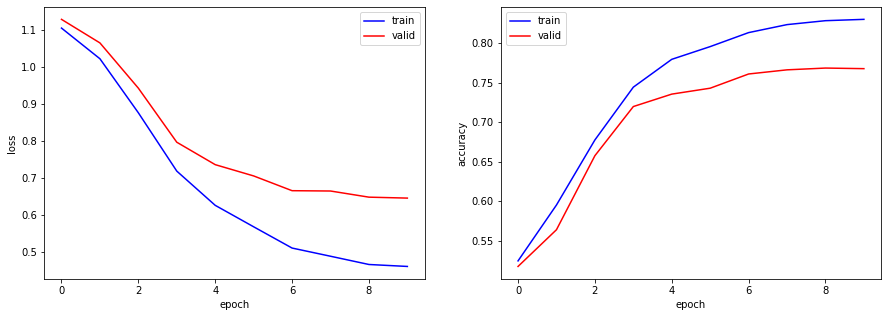

acc_train：0.830
acc_test：0.774


In [12]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 83. ミニバッチ化・GPU上での学習
問題82のコードを改変し，B事例ごとに損失・勾配を計算して学習を行えるようにせよ（Bの値は適当に選べ）．また，GPU上で学習を実行せよ．

In [13]:
class Padsequence():
    def __init__(self, padding_idx):
        self.padding_idx = padding_idx
    
    def __call__(self, batch):
        sorted_batch = sorted(batch, key=lambda x: x['inputs'].shape[0], reverse=True)
        sequences = [x['inputs'] for x in sorted_batch]
        sequences_padded = torch.nn.utils.rnn.pad_sequence(sequences, batch_first=True, 
                                                           padding_value=self.padding_idx)
        labels = torch.LongTensor([x['labels'] for x in sorted_batch])

        return {'inputs': sequences_padded, 'labels': labels}


In [14]:
PADDING_IDX = len(set(word2id.values()))
batch_size = 32
num_epochs = 10
lr = 5e-2

model = RNN(vocab_size, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, num_epochs
                  , collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2584, accuracy_train: 0.4083, loss_valid: 1.2586, accuracy_valid: 0.4250, 8.2297sec
epoch: 2, loss_train: 1.2452, accuracy_train: 0.4391, loss_valid: 1.2551, accuracy_valid: 0.4475, 8.7617sec
epoch: 3, loss_train: 1.1530, accuracy_train: 0.5152, loss_valid: 1.1634, accuracy_valid: 0.5262, 8.4522sec
epoch: 4, loss_train: 1.0202, accuracy_train: 0.6419, loss_valid: 1.0397, accuracy_valid: 0.6297, 8.1606sec
epoch: 5, loss_train: 0.9308, accuracy_train: 0.6964, loss_valid: 0.9565, accuracy_valid: 0.6777, 8.7476sec
epoch: 6, loss_train: 0.8909, accuracy_train: 0.7060, loss_valid: 0.9420, accuracy_valid: 0.6732, 8.1671sec
epoch: 7, loss_train: 0.8272, accuracy_train: 0.7300, loss_valid: 0.8727, accuracy_valid: 0.7046, 9.3685sec
epoch: 8, loss_train: 0.7762, accuracy_train: 0.7517, loss_valid: 0.8261, accuracy_valid: 0.7316, 8.1430sec
epoch: 9, loss_train: 0.7689, accuracy_train: 0.7462, loss_valid: 0.8399, accuracy_valid: 0.7099, 8.2498sec
epoch: 10, loss_train: 0.730

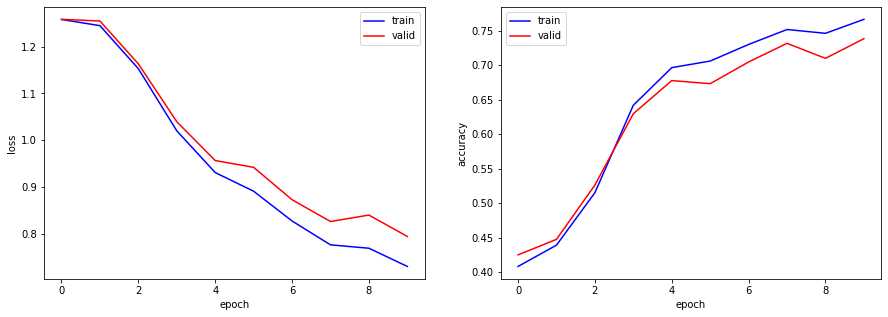

acc_train：0.766
acc_test：0.720


In [15]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 84. 単語ベクトルの導入
事前学習済みの単語ベクトル（例えば，Google Newsデータセット（約1,000億単語）での[学習済み単語ベクトル](https://drive.google.com/file/d/0B7XkCwpI5KDYNlNUTTlSS21pQmM/edit?usp=sharing)）で単語埋め込みemb(x)を初期化し，学習せよ．

colabのRAMがクラッシュするのでスキップ

In [47]:
'''FILE_ID = "0B7XkCwpI5KDYNlNUTTlSS21pQmM"
FILE_NAME = "GoogleNews-vectors-negative300.bin.gz"
!wget --load-cookies /tmp/cookies.txt "https://docs.google.com/uc?export=download&confirm=$(wget --quiet --save-cookies /tmp/cookies.txt --keep-session-cookies --no-check-certificate 'https://docs.google.com/uc?export=download&id=$FILE_ID' -O- | sed -rn 's/.*confirm=([0-9A-Za-z_]+).*/\1\n/p')&id=$FILE_ID" -O $FILE_NAME && rm -rf /tmp/cookies.txt'''

--2023-01-13 05:30:55--  https://docs.google.com/uc?export=download&confirm=&id=0B7XkCwpI5KDYNlNUTTlSS21pQmM
Resolving docs.google.com (docs.google.com)... 172.217.194.138, 172.217.194.101, 172.217.194.100, ...
Connecting to docs.google.com (docs.google.com)|172.217.194.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79hc93kgo9ifi4g0nfgfvjtmkpfbc9ba/1673587800000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=329f5a09-b1d3-4c9c-a129-f530a731716e [following]
--2023-01-13 05:30:57--  https://doc-0g-8s-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/79hc93kgo9ifi4g0nfgfvjtmkpfbc9ba/1673587800000/06848720943842814915/*/0B7XkCwpI5KDYNlNUTTlSS21pQmM?e=download&uuid=329f5a09-b1d3-4c9c-a129-f530a731716e
Resolving doc-0g-8s-docs.googleusercontent.com (doc-0g-8s-docs.googleusercontent.com)... 142.250.4.132, 2404:6800:400

In [51]:
'''from gensim.models import KeyedVectors
model = KeyedVectors.load_word2vec_format('/content/GoogleNews-vectors-negative300.bin.gz', binary=True)
weights = np.zeros((vocab_size, EMB_SIZE))
words_in_pretrained = 0
for i, word in enumerate(word2id.keys()):
    try:
        weights[i] = model[word]
        words_in_pretrained += 1
    except KeyError:
        weights[i] = np.random.normal(scale=0.4, size=(EMB_SIZE, ))
weights = torch.from_numpy(weights.astype((np.float32)))

print(f'学習済みベクトル利用単語数: {words_in_pretrained}/{vocab_size}')
print('weights.size()')'''

学習済みベクトル利用単語数: 9196/9441
weights.size()


In [38]:
import numpy as np

vocab_size = len(set(word2id.values())) + 1
emb_size = 300
weights = np.zeros((vocab_size , emb_size))
wordataset_in_pretrained = 0
for idx , word in enumerate(word2id.keys()):
    if KeyError:
        weights[idx] = np.random.normal(    loc   = 0 , scale = 1 , size=(emb_size ,))#正規化
    else:
        weights[idx] = model[word]
        wordataset_in_pretrained += 1
weights = torch.from_numpy(weights.astype((np.float32)))#torch

In [39]:
class RNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, hidden_size, num_layers, 
                 emb_weights=None, bidirectional=False):
        super().__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers
        #単方向：1, 双方向: 2
        self.num_directions = bidirectional+1
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.rnn = nn.RNN(emb_size, hidden_size, num_layers, bidirectional=bidirectional, 
                          batch_first=True)
        self.fc = nn.Linear(hidden_size*self.num_directions, output_size)
    
    def forward(self, x):
        self.batch_size = x.size()[0]
        hidden = self.init_hidden(x.device)
        emb = self.emb(x)
        out, hideen = self.rnn(emb, hidden)
        out = self.fc(out[:, -1, :])
        return out

    def init_hidden(self, device):
        hidden = torch.zeros(self.num_layers*self.num_directions, self.batch_size, 
                             self.hidden_size, device=device)
        return hidden
        

In [53]:

vocab_size = len(set(word2id.values())) + 1
EMB_SIZE = 300
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
NUM_LAYERS = 1
LEARNING_RATE = 5e-2
BATCH_SIZE = 32
NUM_EPOCHS = 10

model = RNN(vocab_size, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, HIDDEN_SIZE, NUM_LAYERS, emb_weights=weights)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE)
device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, 
                  loss_fn, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 1.2500, accuracy_train: 0.4221, loss_valid: 1.2692, accuracy_valid: 0.4243, 11.7948sec
epoch: 2, loss_train: 1.1726, accuracy_train: 0.5052, loss_valid: 1.1929, accuracy_valid: 0.4880, 10.5940sec


KeyboardInterrupt: ignored

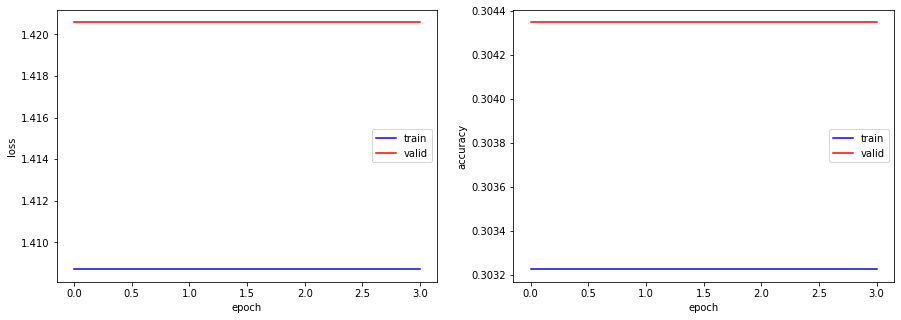

acc_train：0.303
acc_test：0.289


In [41]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 85. 双方向RNN・多層化
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

In [60]:
vocab_size = len(set(word2id.values())) + 1
emb_size = 300
padding_idx = len(set(word2id.values()))
OUTPUT_SIZE = 4
HIDDEN_SIZE = 50
num_layers = 2
lr = 5e-2
batch_size = 32
num_epochs = 10


model = RNN(vocab_size, emb_size, padding_idx, OUTPUT_SIZE, HIDDEN_SIZE, num_layers, 
            emb_weights=weights, bidirectional=True)

loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=lr)
device = torch.device('cuda')

log = train_model(dataset_train, dataset_valid, batch_size, 
                  model, loss_fn, optimizer, num_epochs, collate_fn=Padsequence(padding_idx), device=device)

epoch: 1, loss_train: 1.2242, accuracy_train: 0.4544, loss_valid: 1.2494, accuracy_valid: 0.4430, 8.5687sec
epoch: 2, loss_train: 1.0668, accuracy_train: 0.6176, loss_valid: 1.1016, accuracy_valid: 0.5975, 8.4774sec
epoch: 3, loss_train: 0.9827, accuracy_train: 0.6665, loss_valid: 1.0236, accuracy_valid: 0.6529, 8.4763sec
epoch: 4, loss_train: 1.0243, accuracy_train: 0.6531, loss_valid: 1.0893, accuracy_valid: 0.6087, 8.5188sec
epoch: 5, loss_train: 0.9390, accuracy_train: 0.6909, loss_valid: 0.9771, accuracy_valid: 0.6799, 8.5847sec
epoch: 6, loss_train: 0.9047, accuracy_train: 0.7016, loss_valid: 0.9519, accuracy_valid: 0.6874, 8.4938sec
epoch: 7, loss_train: 0.8443, accuracy_train: 0.7269, loss_valid: 0.8950, accuracy_valid: 0.7091, 9.2191sec
epoch: 8, loss_train: 0.8224, accuracy_train: 0.7336, loss_valid: 0.8897, accuracy_valid: 0.7076, 8.6162sec
epoch: 9, loss_train: 0.8228, accuracy_train: 0.7331, loss_valid: 0.8958, accuracy_valid: 0.7061, 8.5906sec
epoch: 10, loss_train: 0.806

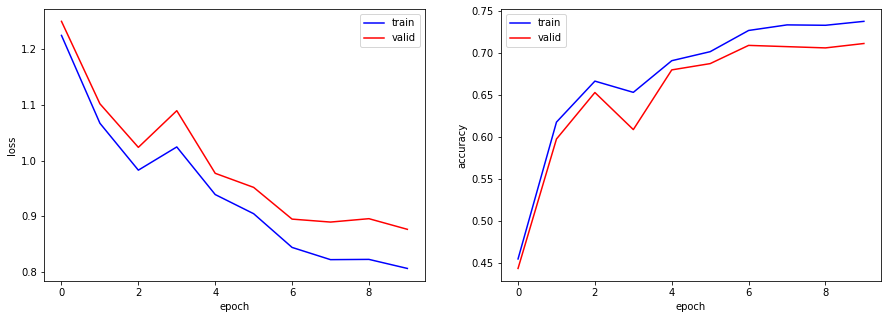

acc_train：0.738
acc_test：0.722


In [61]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 86. 畳み込みニューラルネットワーク (CNN)
※問題文に数式が多く含まれているため、記述しない。<br>
[問題文](https://nlp100.github.io/ja/ch09.html)

In [45]:
from torch.nn import functional as F

class CNN(nn.Module):
    def __init__(self, vocab_size, emb_size, padding_idx, output_size, 
                 out_channels, kernel_heights, stride, padding, emb_weights=None):
        super().__init__()
        if emb_weights != None:
            self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
        else:
            self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
        self.conv = nn.Conv2d(1, out_channels, (kernel_heights, emb_size), stride, 
                              (padding, 0))
        self.drop = nn.Dropout(0.3)
        self.fc = nn.Linear(out_channels, output_size)
    
    def forward(self, x):
        emb = self.emb(x).unsqueeze(1)
        conv = self.conv(emb)
        act = F.relu(conv.squeeze(3))
        max_pool = F.max_pool1d(act, act.size()[2])
        out = self.fc(self.drop(max_pool.squeeze(2)))
        return out

In [57]:
out_channels = 100
kernel_heights = 3
stride = 1
padding = 1

model = CNN(vocab_size, emb_size, padding_idx, OUTPUT_SIZE, 
            out_channels, kernel_heights, stride, padding, emb_weights=weights)

# 先頭10件の予測値取得
for i in range(10):
  X = dataset_train[i]['inputs']
  print(torch.softmax(model(X.unsqueeze(0)), dim=-1))

tensor([[0.3329, 0.2040, 0.1522, 0.3109]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1358, 0.3663, 0.2267, 0.2713]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2441, 0.4609, 0.1501, 0.1449]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1099, 0.2469, 0.1631, 0.4801]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1135, 0.2981, 0.2419, 0.3465]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1231, 0.2753, 0.3294, 0.2723]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2506, 0.1328, 0.2061, 0.4106]], grad_fn=<SoftmaxBackward0>)
tensor([[0.2229, 0.3555, 0.1521, 0.2695]], grad_fn=<SoftmaxBackward0>)
tensor([[0.0847, 0.2846, 0.2833, 0.3474]], grad_fn=<SoftmaxBackward0>)
tensor([[0.1212, 0.3271, 0.1305, 0.4211]], grad_fn=<SoftmaxBackward0>)


### 87. 確率的勾配降下法によるCNNの学習
確率的勾配降下法（SGD: Stochastic Gradient Descent）を用いて，問題86で構築したモデルを学習せよ．訓練データ上の損失と正解率，評価データ上の損失と正解率を表示しながらモデルを学習し，適当な基準（例えば10エポックなど）で終了させよ．



In [58]:
vocab_size = len(set(word2id.values())) + 1
emb_size = 300
padding_idx = len(set(word2id.values()))
OUTPUT_SIZE = 4
out_channels = 100
kernel_heights = 3
stride = 1
padding = 1
lr = 5e-2
batch_size = 64
num_epochs = 10

model = CNN(vocab_size, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, 
            kernel_heights, stride, padding, emb_weights=weights)

# 損失関数の定義
criterion = nn.CrossEntropyLoss()

# オプティマイザの定義
optimizer = torch.optim.SGD(model.parameters(), lr=lr)

# デバイスの指定
device = torch.device('cuda')

# モデルの学習
log = train_model(dataset_train, dataset_valid, batch_size, 
                  model, criterion, optimizer, num_epochs, collate_fn=Padsequence(PADDING_IDX), device=device)

epoch: 1, loss_train: 0.6991, accuracy_train: 0.7699, loss_valid: 0.7811, accuracy_valid: 0.7301, 7.6650sec
epoch: 2, loss_train: 0.4597, accuracy_train: 0.8486, loss_valid: 0.6303, accuracy_valid: 0.7699, 7.6136sec
epoch: 3, loss_train: 0.3162, accuracy_train: 0.8912, loss_valid: 0.5436, accuracy_valid: 0.7909, 8.1508sec
epoch: 4, loss_train: 0.2222, accuracy_train: 0.9418, loss_valid: 0.4994, accuracy_valid: 0.8171, 9.1750sec
epoch: 5, loss_train: 0.1704, accuracy_train: 0.9635, loss_valid: 0.4909, accuracy_valid: 0.8238, 7.9408sec
epoch: 6, loss_train: 0.1362, accuracy_train: 0.9746, loss_valid: 0.4702, accuracy_valid: 0.8298, 8.8787sec
epoch: 7, loss_train: 0.1176, accuracy_train: 0.9773, loss_valid: 0.4598, accuracy_valid: 0.8336, 8.5543sec
epoch: 8, loss_train: 0.1043, accuracy_train: 0.9852, loss_valid: 0.4586, accuracy_valid: 0.8351, 7.6342sec
epoch: 9, loss_train: 0.0991, accuracy_train: 0.9871, loss_valid: 0.4576, accuracy_valid: 0.8388, 7.6012sec
epoch: 10, loss_train: 0.098

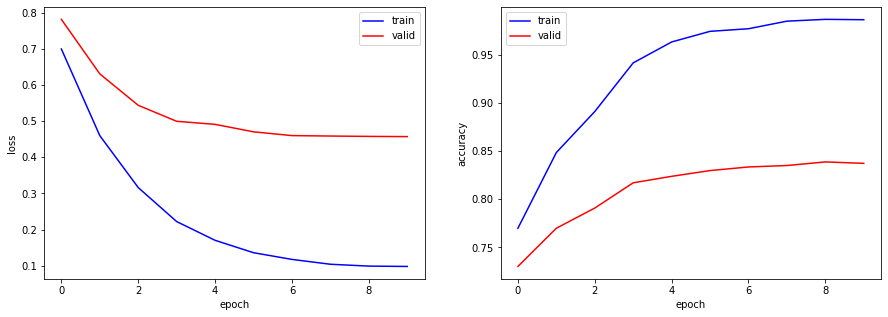

acc_train：0.987
acc_test：0.857


In [59]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 88. パラメータチューニング
問題85や問題87のコードを改変し，ニューラルネットワークの形状やハイパーパラメータを調整しながら，高性能なカテゴリ分類器を構築せよ．



In [48]:
class textCNN(nn.Module):
  def __init__(self, vocab_size, emb_size, padding_idx, output_size, out_channels, conv_params, drop_rate, emb_weights=None):
    super().__init__()
    if emb_weights != None:  
      self.emb = nn.Embedding.from_pretrained(emb_weights, padding_idx=padding_idx)
    else:
      self.emb = nn.Embedding(vocab_size, emb_size, padding_idx=padding_idx)
    self.convs = nn.ModuleList([nn.Conv2d(1, out_channels, 
                                          (kernel_height, emb_size), padding=(padding, 0)) for kernel_height, padding in conv_params])
    self.drop = nn.Dropout(drop_rate)
    self.fc = nn.Linear(len(conv_params) * out_channels, output_size)
    
  def forward(self, x):
    # x.size() = (batch_size, seq_len)
    emb = self.emb(x).unsqueeze(1)
    # emb.size() = (batch_size, 1, seq_len, emb_size)
    conv = [F.relu(conv(emb)).squeeze(3) for i, conv in enumerate(self.convs)]
    # conv[i].size() = (batch_size, out_channels, seq_len + padding * 2 - kernel_height + 1)
    max_pool = [F.max_pool1d(i, i.size(2)) for i in conv]
    # max_pool[i].size() = (batch_size, out_channels, 1) -> seq_len方向に最大値を取得
    max_pool_cat = torch.cat(max_pool, 1)
    # max_pool_cat.size() = (batch_size, len(conv_params) * out_channels, 1)  -> フィルター別の結果を結合
    out = self.fc(self.drop(max_pool_cat.squeeze(2)))
    # out.size() = (batch_size, output_size)
    return out

In [49]:
!pip install optuna

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [50]:
import optuna

def objective(trial):
    emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
    out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
    drop_rate = trial.suggest_discrete_uniform('drop_rate', 0.0, 0.5, 0.1)
    learning_rate = trial.suggest_loguniform('learning_rate', 5e-4, 5e-2)
    momentum = trial.suggest_discrete_uniform('momentum', 0.5, 0.9, 0.1)
    batch_size = int(trial.suggest_discrete_uniform('batch_size', 16, 128, 16))

    vocab_size = len(set(word2id.values())) + 1
    PADDING_IDX = len(set(word2id.values()))
    OUTPUT_SIZE = 4
    CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
    NUM_EPOCHS = 30

    model = textCNN(vocab_size, emb_size, PADDING_IDX, OUTPUT_SIZE, out_channels, CONV_PARAMS, drop_rate, )#emb_weights=weights)
    loss_fn = nn.CrossEntropyLoss()
    optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate, momentum=momentum)
    device = torch.cuda.set_device(0)
    log = train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
    loss_valid, _ = calculate_loss_and_accuracy(model, dataset_valid, device, loss_fn=loss_fn) 

    return loss_valid 

In [51]:
study = optuna.create_study()
study.optimize(objective, timeout=7200)

print('Best trial:')
trial = study.best_trial
print('  Value: {:.3f}'.format(trial.value))
print('  Params: ')
for key, value in trial.params.items():
    print('    {}: {}'.format(key, value))

[I 2023-01-13 06:32:14,887] A new study created in memory with name: no-name-761f02a5-f172-43ea-a29d-e8c683a46167
<ipython-input-50-9633017da695>:4: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  emb_size = int(trial.suggest_discrete_uniform('emb_size', 100, 400, 100))
<ipython-input-50-9633017da695>:5: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :func:`~optuna.trial.Trial.suggest_float` instead.
  out_channels = int(trial.suggest_discrete_uniform('out_channels', 50, 200, 50))
<ipython-input-50-9633017da695>:6: FutureWarning: suggest_discrete_uniform has been deprecated in v3.0.0. This feature will be removed in v6.0.0. See https://github.com/optuna/optuna/releases/tag/v3.0.0. Use :f

epoch: 1, loss_train: 0.9141, accuracy_train: 0.6845, loss_valid: 0.9413, accuracy_valid: 0.6694, 41.0510sec
epoch: 2, loss_train: 0.7248, accuracy_train: 0.7450, loss_valid: 0.8055, accuracy_valid: 0.7099, 34.0753sec
epoch: 3, loss_train: 0.6059, accuracy_train: 0.7850, loss_valid: 0.7239, accuracy_valid: 0.7294, 38.7667sec
epoch: 4, loss_train: 0.4962, accuracy_train: 0.8153, loss_valid: 0.6604, accuracy_valid: 0.7601, 33.3378sec
epoch: 5, loss_train: 0.4062, accuracy_train: 0.8556, loss_valid: 0.6154, accuracy_valid: 0.7774, 34.0289sec
epoch: 6, loss_train: 0.3242, accuracy_train: 0.9071, loss_valid: 0.5702, accuracy_valid: 0.8006, 33.8380sec
epoch: 7, loss_train: 0.2774, accuracy_train: 0.9140, loss_valid: 0.5544, accuracy_valid: 0.8058, 33.1143sec
epoch: 8, loss_train: 0.2187, accuracy_train: 0.9573, loss_valid: 0.5244, accuracy_valid: 0.8111, 34.8841sec
epoch: 9, loss_train: 0.1809, accuracy_train: 0.9665, loss_valid: 0.5064, accuracy_valid: 0.8111, 32.9212sec
epoch: 10, loss_tra

[I 2023-01-13 06:45:55,859] Trial 0 finished with value: 0.4586099451224317 and parameters: {'emb_size': 300.0, 'out_channels': 150.0, 'drop_rate': 0.30000000000000004, 'learning_rate': 0.0032723394358432772, 'momentum': 0.8, 'batch_size': 64.0}. Best is trial 0 with value: 0.4586099451224317.


epoch: 1, loss_train: 0.7414, accuracy_train: 0.7365, loss_valid: 0.8071, accuracy_valid: 0.7031, 27.8203sec
epoch: 2, loss_train: 0.5133, accuracy_train: 0.8230, loss_valid: 0.6615, accuracy_valid: 0.7526, 26.5311sec
epoch: 3, loss_train: 0.3495, accuracy_train: 0.9100, loss_valid: 0.5815, accuracy_valid: 0.7991, 26.5935sec
epoch: 4, loss_train: 0.2352, accuracy_train: 0.9501, loss_valid: 0.5181, accuracy_valid: 0.8216, 27.7589sec
epoch: 5, loss_train: 0.1631, accuracy_train: 0.9817, loss_valid: 0.4900, accuracy_valid: 0.8231, 26.8286sec
epoch: 6, loss_train: 0.1152, accuracy_train: 0.9902, loss_valid: 0.4681, accuracy_valid: 0.8253, 27.2707sec
epoch: 7, loss_train: 0.0858, accuracy_train: 0.9963, loss_valid: 0.4638, accuracy_valid: 0.8336, 27.6523sec
epoch: 8, loss_train: 0.0657, accuracy_train: 0.9979, loss_valid: 0.4599, accuracy_valid: 0.8373, 27.5309sec
epoch: 9, loss_train: 0.0535, accuracy_train: 0.9986, loss_valid: 0.4586, accuracy_valid: 0.8433, 27.0144sec
epoch: 10, loss_tra

[I 2023-01-13 06:54:31,012] Trial 1 finished with value: 0.4529925961678792 and parameters: {'emb_size': 400.0, 'out_channels': 50.0, 'drop_rate': 0.0, 'learning_rate': 0.0033894131743360807, 'momentum': 0.8, 'batch_size': 48.0}. Best is trial 1 with value: 0.4529925961678792.


epoch: 1, loss_train: 0.5802, accuracy_train: 0.8079, loss_valid: 0.7152, accuracy_valid: 0.7466, 41.5309sec
epoch: 2, loss_train: 0.3036, accuracy_train: 0.9170, loss_valid: 0.5732, accuracy_valid: 0.7901, 42.1773sec
epoch: 3, loss_train: 0.1438, accuracy_train: 0.9813, loss_valid: 0.4803, accuracy_valid: 0.8373, 42.7928sec
epoch: 4, loss_train: 0.0781, accuracy_train: 0.9929, loss_valid: 0.4590, accuracy_valid: 0.8418, 42.6364sec
epoch: 5, loss_train: 0.0442, accuracy_train: 0.9950, loss_valid: 0.4544, accuracy_valid: 0.8501, 43.2018sec
epoch: 6, loss_train: 0.0299, accuracy_train: 0.9978, loss_valid: 0.4612, accuracy_valid: 0.8501, 43.1492sec
epoch: 7, loss_train: 0.0225, accuracy_train: 0.9984, loss_valid: 0.4631, accuracy_valid: 0.8471, 42.7823sec
epoch: 8, loss_train: 0.0149, accuracy_train: 0.9989, loss_valid: 0.4597, accuracy_valid: 0.8568, 42.7510sec
epoch: 9, loss_train: 0.0120, accuracy_train: 0.9991, loss_valid: 0.4774, accuracy_valid: 0.8463, 42.0383sec
epoch: 10, loss_tra

[W 2023-01-13 07:03:43,833] Trial 2 failed because of the following error: KeyboardInterrupt()
Traceback (most recent call last):
  File "/usr/local/lib/python3.8/dist-packages/optuna/study/_optimize.py", line 196, in _run_trial
    value_or_values = func(trial)
  File "<ipython-input-50-9633017da695>", line 21, in objective
    log = train_model(dataset_train, dataset_valid, batch_size, model, loss_fn, optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)
  File "<ipython-input-9-455194217bee>", line 53, in train_model
    torch.save({'epoch': epoch, 'model_state_dict': model.state_dict(), 'optimizer_state_dict': optimizer.state_dict()}, f'checkpoint{epoch + 1}.pt')
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 423, in save
    _save(obj, opened_zipfile, pickle_module, pickle_protocol)
  File "/usr/local/lib/python3.8/dist-packages/torch/serialization.py", line 650, in _save
    zip_file.write_record(name, storage.data_ptr(), num_byt

KeyboardInterrupt: ignored

In [ ]:
vocab_size = len(set(word2id.values())) + 1
EMB_SIZE = int(trial.params['emb_size'])
PADDING_IDX = len(set(word2id.values()))
OUTPUT_SIZE = 4
OUT_CHANNELS = int(trial.params['out_channels'])
CONV_PARAMS = [[2, 0], [3, 1], [4, 2]]
DROP_RATE = trial.params['drop_rate']
LEARNING_RATE = trial.params['learning_rate']
BATCH_SIZE = int(trial.params['batch_size'])
NUM_EPOCHS = 30

In [ ]:
model = textCNN(vocab_size, EMB_SIZE, PADDING_IDX, OUTPUT_SIZE, OUT_CHANNELS, CONV_PARAMS, DROP_RATE)#, emb_weights=weights)
print(model)
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=LEARNING_RATE, momentum=0.9)
device = torch.cuda.set_device(0)
log = train_model(dataset_train, dataset_valid, BATCH_SIZE, model, loss_fn,
                  optimizer, NUM_EPOCHS, collate_fn=Padsequence(PADDING_IDX), device=device)

In [ ]:
visualize_logs(log)

# 正解率の算出
_, acc_train = calculate_loss_and_accuracy(model, dataset_train, device=device)
_, acc_test = calculate_loss_and_accuracy(model, dataset_test, device=device)
print(f'acc_train：{acc_train:.3f}')
print(f'acc_test：{acc_test:.3f}')

### 89. 事前学習済み言語モデルからの転移学習
事前学習済み言語モデル（例えば[BERT](https://github.com/google-research/bert)など）を出発点として，ニュース記事見出しをカテゴリに分類するモデルを構築せよ．

In [ ]:
!pip install transformers

In [ ]:
import transformers
from transformers import BertTokenizer, BertModel
from torch import optim
from torch import cuda

https://amaru-ai.com/entry/2022/10/15/202442#%E7%92%B0%E5%A2%83%E8%A8%AD%E5%AE%9A